In [1]:
# import pandas for data wrangling
import pandas as pd


# import numpy for Scientific computations
import numpy as np


# import machine learning libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score


# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# Any results you write to the current directory are saved as output.

In [2]:
def read_data(file):    
    df_all_v1 = pd.read_csv(file)
    try:
        df_all_v1 = df_all_v1.drop(['Unnamed: 0', 'Registration_date', 'EMTAK_by_number', 'Client_ID_by_Eesti_Pank'],axis=1)
    except: 
        df_all_v1 = df_all_v1.drop(['Registration_date', 'EMTAK_by_number', 'Client_ID_by_Eesti_Pank'],axis=1)
        
    df_all_v1 = df_all_v1.sort_values(by=['year_quarter'])
    
    return df_all_v1

In [3]:
files = [#'./data/full_v1.csv',
#         './data/full_v2.csv',
#         './data/before_v1.csv',
#         './data/before_v2.csv',
        './data/during_v1.csv',
        './data/during_v2.csv']

dfs = {}
for file in files:
    name = file.split('/')[2]
    df = read_data(file)
    dfs[name] = df
    #break

In [4]:
data = dfs['during_v1.csv'].reset_index(drop=True)
data = data.drop([ 'Registration_number', 'year_quarter'], axis=1)
data['label'] = [2 if label == 'growing' else 1 if label == 'stable' else 0 for label in data['label']]

train_df, test_df = np.split(data, [int(0.3 *len(df))]) 
train_df.shape, test_df.shape

((164194, 15), (383122, 15))

In [5]:
best_hyperparams = {'colsample_bytree': 0.6000000000000001, 'eta': 0.125, 'gamma': 0.65, 'max_depth': 2, 'min_child_weight': 2.0, 'n_estimators': 995.0, 'subsample': 0.7000000000000001}


In [6]:
y_train = np.array(train_df['label'])
X_train = train_df.drop(['label'], axis=1)


y_test = np.array(test_df['label'])
X_test = test_df.drop(['label'], axis=1)

clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
         gamma=best_hyperparams['gamma'], max_delta_step=0.0, min_child_weight=best_hyperparams['min_child_weight'],
         missing=None, n_jobs=-1, objective='multi:softprob', random_state=42, reg_alpha=0.0,
         reg_lambda=1.0, scale_pos_weight=1.0, tree_method='auto',
         colsample_bytree =best_hyperparams['colsample_bytree'], 
         eta = best_hyperparams['eta'], 
         max_depth = best_hyperparams['max_depth'], 
         subsample = best_hyperparams['subsample'], 
         n_estimators = int(best_hyperparams['n_estimators']),
                          nthread= 4, use_label_encoder=False)
mcl = clf.fit(X_train, y_train)
#predicting the data
y_pred = clf.predict(X_test)
y_prob_pred = clf.predict_proba(X_test)
pred = mcl.predict(X_test)
proba = mcl.predict_proba(X_test)

#store our flower labels for results
y_map = pd.DataFrame(data=data['label'], columns=['class'])
y_map['label'] = y_map['class'].map({0:'Failing',1:'Stabel',2:'Growing'})



[12:22:48] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:22:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [7]:
import shap
import math

In [31]:
xgc = mcl
explainer = shap.TreeExplainer(xgc)
shap_values = explainer.shap_values(X_test)


In [35]:
np.array(['Failing', 'Stabel', 'Growing'])

array(['Failing', 'Stabel', 'Growing'], dtype='<U7')

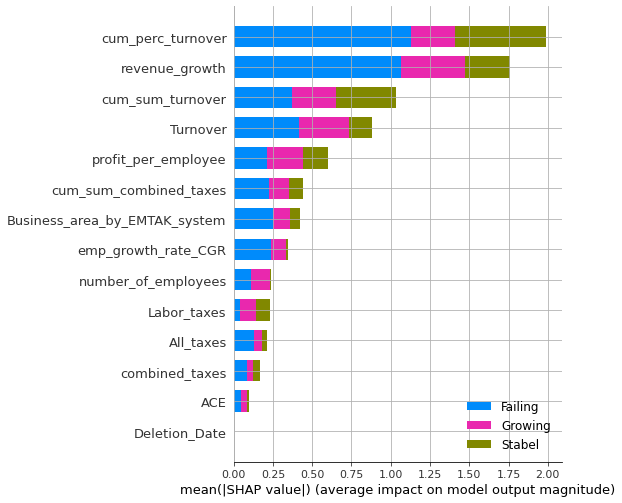

In [38]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, X_test, show=False, class_names=np.array(['Failing', 'Stabel', 'Growing']))
plt.tight_layout()
plt.grid(True)
pl.savefig("./summary_plot.pdf")